# Ptychography: extended Ptychographic Iterative Engine (ePIE) 


In [1]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(cores=1,
                       memory ='80GB',
                       walltime="12:00:00")

In [2]:
# Call at head node, otherwise you won't get the dashboard
from dask.distributed import Client
cluster.scale(1) # number of nodes you request
client = Client(cluster)
client

Client Scheduler: tcp://128.104.200.53:40665 Dashboard: http://128.104.200.53:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


[go to top](#toc)

## 3. Preparation<a name="prep"/> 

<span style="color:orange"> Add the path to the folder ptycho_recon </span> which contains the functions for the 4D data processing and the ptychographic reconstruction in the command sys.path.append("__")

In [1]:
import sys
sys.path.append("/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/ptycho_recon/") #add ptycho_recon path
# Restart kernel after that
import numpy as np
import os #for change directory
import scipy.io as sio #for read/write matlab file
#import scipy.ndimage.filters as sfilter
import scipy.ndimage
#import scipy.misc
import matplotlib.pyplot as plt
%matplotlib notebook
import ptycho_recon as pty
from ptycho_recon import utility_function as utils
from ptycho_recon import probe as probe
from ptycho_recon import postProcess as postProcess
from ptycho_recon import browser
from ptycho_recon import ptycho as ptycho
###
#from ptycho_recon import filters
###
#import h5py
from IPython.display import Video

from numpy import *
import time

[go to top](#toc)
## 4. Read Data and Set Experimental Parameters <a name="load"/>

1. Input the path to the 4D dataset here 
2. Set parameters for preprocessing and size of the diffraction patterns (default vaules, can be changed) 
3. Load or enter different experimental parameters (critical for proper reconstruction) 

In [2]:
print("input data path and some data related parameters")

######################################### Parameters ##################################### 

data_name = 'WS2_movie389_scan300_428.mat'
data_dir = '/srv/home/jwei74/Ptychography/20211115/movie389/'
N_roi = 128 #Size of square diffraction patterns
#rot_angle_d = 103.5-98 #(degree) Rotate the real space object instead of DP
rot_angle_d = -101
result_dir_extra0 = 'WS2_test1'  # string for specific output folder name
ADU_background_cutoff = 7 #Threshold that below which would be removed
ADU_electronCount_ratio = 241.0 # factor needed to convert between detector output and actual electron counts 

##################################### read data ########################################
os.chdir(data_dir) #change to data directory
path = os.getcwd()
data = sio.loadmat(data_name)
print('variables loaded:')
print(data.keys())
      

input data path and some data related parameters
variables loaded:
dict_keys(['__header__', '__version__', '__globals__', 'alpha_max', 'crop_idx', 'df', 'cs', 'dk', 'dp', 'lambda', 'scanStepSize_x', 'scanStepSize_y', 'voltage'])


The *.mat data file contains the 4D diffraction (dp), probe forming semi-angle (alpha_max), spherical aberration (cs), focus (df), pixel size in diffraction plane (dk), scan step size (scanStepSize_x/y), and beam voltage (voltage). 


In [24]:
########################################################################################

dp = data['dp']*1.0 #4D Diffraction patterns
#dp = np.moveaxis(data['dp'], [0, 1], [2, 3])

N_dp = dp.shape[0]

# parameters read from example *.mat file 
# if any of parameters to change, mannually input the corresponding variable

sx = 0 if not 'sx' in data else int(squeeze(data['sx'])) 
sy = 0 if not 'sy' in data else int(squeeze(data['sy']))
voltage = squeeze(data['voltage']) # kev
alpha_max = squeeze(data['alpha_max']) # mrad
df = squeeze(data['df']) # defocus (angstrom)
cs = squeeze(data['cs']) # spherical aberration (mm)
scanStepSize_x = squeeze(data['scanStepSize_x'])
scanStepSize_y = squeeze(data['scanStepSize_y'])

dk = squeeze(data['dk']) # reciprocal space pixel size (inverse angstrom)
print("dk =", dk)
dx = 1.0/dk/N_roi # real space pixel size (angstrom)
print("dx =", dx)

################################## data processing ##########################################
print("processing data")
result_dir_extra = "_preprocessCBED" #Directory name of output
#dp, result_dir_extra = utils.transpose_cbed(dp, result_dir_extra) #Transpose scan direction x &y and update the directory name
#Set pixels that are less than threshold to 0 and update directory name
dp, result_dir_extra = utils.background_removal(dp, ADU_background_cutoff, result_dir_extra)

print("recon data size:", dp.shape)

dk = 0.11316
dx = 0.06903941322021916
processing data
removing background: threshold= 7
recon data size: (128, 128, 128, 128)


Raw experimental data may need some pre-processing, such as matrix rotation or transpose or background removing. Related functions can be found in utility_function.py. 

### What does the 4D data look like?

<IPython.core.display.Javascript object>


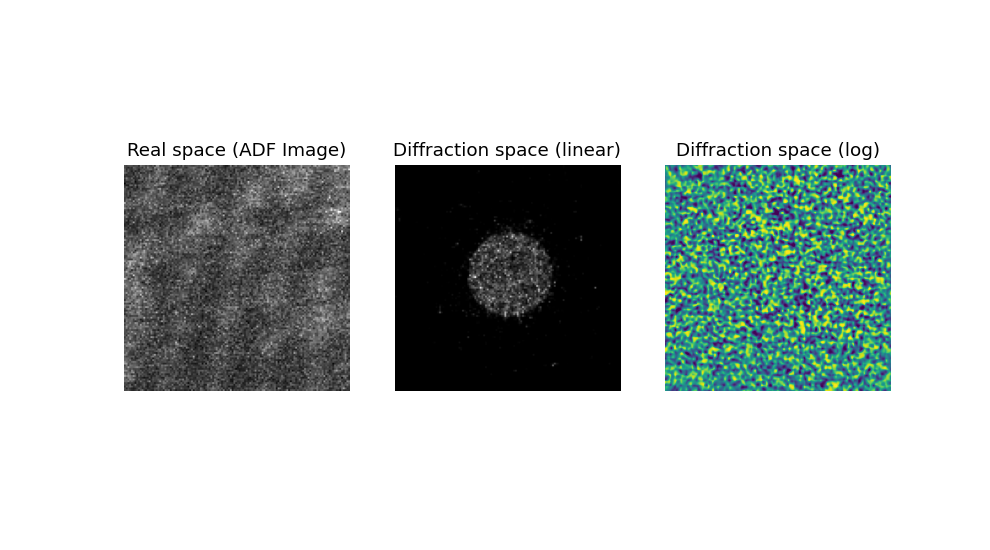

In [25]:
guis=browser.browser( np.transpose(dp, (2,3,0,1)) )
#guis=browser.browser(dp)

[go to top](#toc)
## 5. Initialize probe and probe positions <a name="probe"/>
Before we start ptychography, we need an initial probe and define the coordinates of the probe positions.

In [26]:
################################## make initial probe function ##################################
probe_init = probe.STEMprobe()
probe_init.df = df
probe_init.cs = cs
probe_init.alpha_max = alpha_max
probe_init.voltage = voltage

################################## calculate scan positions ####################################
#calculate scan positions
N_scan_y = dp.shape[2]
N_scan_x = dp.shape[3]

#Generate the arrays of the scanning positions after scanning rotation correction and update the info in the directory
ppX, ppY, result_dir_extra = utils.calculate_scan_positions(N_scan_x, N_scan_y, scanStepSize_x, scanStepSize_y, rot_angle_d, result_dir_extra)

Ny_max = max([abs(round(np.min(ppY)/dx)-floor(N_roi/2.0)), abs(round(np.max(ppY)/dx)+ceil(N_roi/2.0))])*2+1
Nx_max = max([abs(round(np.min(ppX)/dx)-floor(N_roi/2.0)), abs(round(np.max(ppX)/dx)+ceil(N_roi/2.0))])*2+1

#Extend the size of the object to accommondate position correction, and will crop later
N_image = int(max([Ny_max,Nx_max]))+20
print("Image size:", N_image)

calculate scan positions
N_scan_x = 128 scanStepSize_x = 0.1
N_scan_y = 128 scanStepSize_y = 0.1
rot_angle = -101
Image size: 367


### CHECKPOINT 1: 
   <span style="color:red"> 1). How to generate a STEM probe function? (Refer to session T1-Imaging) </span> <br> 

   <span style="color:red"> 2). How can we define the coordinates of probe positions? </span> <br> 

1). T1-Imaging teaches how to simulate a point spread function(PSF) given the convergence angle, beam voltage and aberration information. Review that section if you don't remember how to generate the probe function.

2). We need to know the calibrated scan step size on each direction and corresponding real space dimensions. Then we can generate a meshgrid of 2D scan coordinates.

[go to top](#toc)
## 6. Set reconstruction parameters <a name="recon_param"/>
The major ptychography routine calls a class variable called reconObject. Parameters are input into paraDict. Some important parameters must be set. More default parameters can be found in ptycho.py.

In [27]:
########################################### reconstruction #####################################
print('Set reconstruction parameters')
reconObject = ptycho.ptycho(dp, dk, probe_init, ppX, ppY)
reconObject.paraDict['dk_y'] = dk
reconObject.paraDict['dk_x'] = dk
reconObject.paraDict['N_image'] = N_image 
reconObject.paraDict['N_roi'] = N_roi #Size of ROI
reconObject.paraDict['Niter'] = 10 #Number of iterations
reconObject.paraDict['Niter_update_probe'] = 0 #Update probe from the 1st iteration
reconObject.paraDict['Niter_save'] = 2 #How often to save the reconstruction results

reconObject.paraDict['beta'] = 1 #Learning rate for updating probe
reconObject.paraDict['alpha'] = 0.1 #Learning rate for updating object

reconObject.paraDict['rotationAngle']  = rot_angle_d

reconObject.paraDict['printID'] = 'WS2' #sample label

Set reconstruction parameters


[go to top](#toc)
## 7. Reconstruction <a name="recon"/>

### a). First pass <a name="first"/>

In [28]:
################################################################
#result_dir = data_dir + "/mos2_" + result_dir_extra0
result_dir = data_dir + result_dir_extra0
result_dir_extra = reconObject.initialize(result_dir) #Load the predefined parameters

#print(reconObject.paraDict['saveName'])
start_time = time.time()
reconObject.recon() #start reconstruction
total_time = time.time() - start_time

timeLeftMin, timeLeftSec = divmod(total_time, 60)
timeLeftHour, timeLeftMin = divmod(timeLeftMin, 60)
print('Total recon time: %02d:%02d:%02d' %(timeLeftHour,timeLeftMin,timeLeftSec))


generating probe function...
begin ptychographic reconstruction
WS2-Iter:0 Time remain: 00:00:00
start probe update
WS2-Iter:1 Time remain: 00:14:48
WS2-Iter:2 Time remain: 00:13:10
WS2-Iter:3 Time remain: 00:11:32
WS2-Iter:4 Time remain: 00:09:53
WS2-Iter:5 Time remain: 00:08:14
WS2-Iter:6 Time remain: 00:06:35
WS2-Iter:7 Time remain: 00:04:56
WS2-Iter:8 Time remain: 00:03:17
WS2-Iter:9 Time remain: 00:01:38
Total recon time: 00:16:29


### CHECKPOINT 3: <span style="color:red"> What can we get? </span> <br> 
1. Find the path of the saved results
2. Let's do some plotting

1.) The path is "./mos2_" + result_dir_extra0 which is "test1" here.
See how you can change the name of the output folder.

2.) Plotting is done by loading the saved iterative results of probe and object and doing post processing.

[go to top](#toc)
### b) Monitor the probe and object change <a name="plot"/>
 check how to generate correct probe and object from blank/ideal ones

<IPython.core.display.Javascript object>


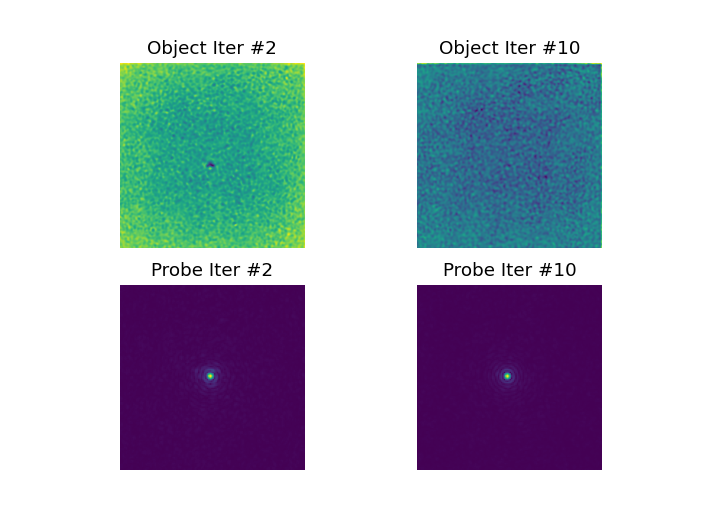

./WS2_test1/recon_Niter2.mat
./WS2_test1/recon_Niter10.mat


In [4]:
os.chdir(path)
#### one example for plots ###
Niters=[2,10]  # read in results from some iterations
fig2, ax2 = plt.subplots(nrows=2, ncols=len(Niters))
plt.figure(1, figsize = (20,20))
for kk in range(len(Niters)):
    prev_recon_name = "./" + result_dir_extra0 + "/" + "recon_Niter" + str(Niters[kk]) + ".mat"
    prev_recon_data = sio.loadmat(prev_recon_name)
    print(prev_recon_name)
    obj=prev_recon_data['object']
    prb=prev_recon_data['probes']
    px = prev_recon_data['ppX']
    py = prev_recon_data['ppY']
    dx = prev_recon_data['dx_x']
    obj_crop = postProcess.postProcess(obj, rot_angle_d, px, py, dx)
    #ax2[0,kk].imshow( np.angle(obj_crop) )
    ax2[0,kk].imshow(np.absolute(obj_crop))
    ax2[0,kk].axis('off') 
    ax2[0,kk].set_title('Object Iter #' + str(Niters[kk]) )   
    for jj in range(prb.shape[0]):
        ax2[jj+1,kk].imshow( np.abs(prb[jj,:,:]) )
        ax2[jj+1,kk].axis('off') 
        if prb.shape[0] == 1 :
            title_str='Probe Iter #' + str(Niters[kk])
        else:                
            title_str='Probe Mode #' + str(jj+1)
        ax2[jj+1,kk].set_title(title_str) 
        

In [33]:
def enhance_contrast(image_matrix, bins=256):
    image_flattened = image_matrix.flatten()
    image_hist = np.zeros(bins)

    # frequency count of each pixel
    for pix in image_matrix:
        image_hist[pix] += 1

    # cummulative sum
    cum_sum = np.cumsum(image_hist)
    norm = (cum_sum - cum_sum.min()) * 255
    # normalization of the pixel values
    n_ = cum_sum.max() - cum_sum.min()
    uniform_norm = norm / n_
    uniform_norm = uniform_norm.astype('int')

    # flat histogram
    image_eq = uniform_norm[image_flattened]
    # reshaping the flattened matrix to its original shape
    image_eq = np.reshape(a=image_eq, newshape=image_matrix.shape)

    return image_eq
def map8bit(data):
      return ((data - data.min())/(data.max() - data.min())*255).astype('int8')

In [34]:
an = np.angle(obj_crop)
from PIL import Image
imgh = enhance_contrast(map8bit(an))
plt.imshow(imgh)
plt.axis('off')
img = np.asarray(imgh,dtype=np.uint16)
#Image.fromarray(img).save('/srv/home/jwei74/Ptychography/20200704/movie68/mos2_WS2_test1_optimization' + 'phase.tif')

### <span style="color:red"> CHECKPOINT 4: Probe shape? </span> <br> 

We use an ideal aberration free probe as an initial start, but the real probe has 3-fold astigmatism (A2, refer to session T1-imaging). 


[go to top](#toc)
## 9. Further improvements with more iterations and position refinement <a name="improve"/>
<span style="color:red"> If you have changed parameters in the previous session, you will need to restore the correct ones</span><br>

<span style="color:red">Calculate positions of a 256x256 scan with rotation angle -101 tooks a long time. But with GPU is fine. </span><br>


Keep in mind that the original correct parameters are stored in data (*.mat) file.

In [35]:
## Let's restore the correct parameters from data

alpha_max = squeeze(data['alpha_max']) # mrad
scanStepSize_x = squeeze(data['scanStepSize_x'])
scanStepSize_y = squeeze(data['scanStepSize_y'])
probe_init.alpha_max = alpha_max

N_roi = 128 #Size of square diffraction patterns

dk = squeeze(data['dk']) # reciprocal space pixel size (inverse angstrom)
dx = 1.0/dk/N_roi # real space pixel size (angstrom)
ppX, ppY, result_dir_extra = utils.calculate_scan_positions(N_scan_x, N_scan_y, scanStepSize_x, scanStepSize_y, rot_angle_d, result_dir_extra)

Ny_max = max([abs(round(np.min(ppY)/dx)-floor(N_roi/2.0)), abs(round(np.max(ppY)/dx)+ceil(N_roi/2.0))])*2+1
Nx_max = max([abs(round(np.min(ppX)/dx)-floor(N_roi/2.0)), abs(round(np.max(ppX)/dx)+ceil(N_roi/2.0))])*2+1

#Extend the size of the object to accommondate position correction, and will crop later
N_image = int(max([Ny_max,Nx_max]))+20


reconObject = ptycho.ptycho(dp, dk, probe_init, ppX, ppY)
reconObject.paraDict['dk_y'] = dk
reconObject.paraDict['dk_x'] = dk
reconObject.paraDict['N_image'] = N_image 
reconObject.paraDict['N_roi'] = N_roi #Size of ROI
reconObject.paraDict['Niter'] = 20 #Number of iterations
reconObject.paraDict['Niter_update_probe'] = 0 #Update probe from the 1st iteration
reconObject.paraDict['Niter_save'] = 5 #How often to save the reconstruction results

reconObject.paraDict['beta'] = 1 #Learning rate for updating probe
reconObject.paraDict['alpha'] = 0.1 #Learning rate for updating object

reconObject.paraDict['rotationAngle']  = rot_angle_d

calculate scan positions
N_scan_x = 128 scanStepSize_x = 0.1
N_scan_y = 128 scanStepSize_y = 0.1
rot_angle = -101


We can use a previous run as a better initial guess to help get the convergent solution.

Let's grab the path of a good previous run first and load the probes and object as the initial start.

In [6]:
result_dir_extra_opt = 'optimization'

############## load existing probe and object ##############

prev_recon_name = data_dir + result_dir_extra0 + "/" + "recon_Niter10.mat"
print(prev_recon_name)

prev_recon_data = sio.loadmat(prev_recon_name)
reconObject.paraDict['probes0'] = prev_recon_data['probes'] #mixed states opr\n",
reconObject.paraDict['previous_obj'] = prev_recon_data['object'] #mixed states opr\n",

/srv/home/jwei74/Ptychography/20211115/movie389/WS2_test1/recon_Niter10.mat


NameError: name 'reconObject' is not defined

We can use more iterations and better sampling to improve the reconstruction. But it needs more time!

In [37]:
reconObject.paraDict['Niter'] = 50 #Number of iterations
reconObject.paraDict['Niter_save'] = 10 #How often to save the reconstruction results
############## position correction ##############
reconObject.paraDict['Niter_update_position'] = 10 #Since which iteration to update positions

result_dir = data_dir + result_dir_extra0 + '_' + result_dir_extra_opt
result_dir_extra = reconObject.initialize(result_dir) #Load the predefined parameters

print(reconObject.paraDict['saveName'])
start_time = time.time()
reconObject.recon() #start reconstruction
total_time = time.time() - start_time

timeLeftMin, timeLeftSec = divmod(total_time, 60)
timeLeftHour, timeLeftMin = divmod(timeLeftMin, 60)
print('Total recon time: %02d:%02d:%02d' %(timeLeftHour,timeLeftMin,timeLeftSec))

generating probe function...
recon
begin ptychographic reconstruction
-Iter:0 Time remain: 00:00:00
start probe update
-Iter:1 Time remain: 01:22:29
-Iter:2 Time remain: 01:20:09
-Iter:3 Time remain: 01:18:16
-Iter:4 Time remain: 01:16:33
-Iter:5 Time remain: 01:14:52
-Iter:6 Time remain: 01:13:14
-Iter:7 Time remain: 01:11:30
-Iter:8 Time remain: 01:09:50
-Iter:9 Time remain: 01:08:13
-Iter:10 Time remain: 01:06:36
start position correction
-Iter:11 Time remain: 01:29:21
-Iter:12 Time remain: 01:27:04
-Iter:13 Time remain: 01:24:33
-Iter:14 Time remain: 01:22:09
-Iter:15 Time remain: 01:19:42
-Iter:16 Time remain: 01:17:18
-Iter:17 Time remain: 01:15:03
-Iter:18 Time remain: 01:12:56
-Iter:19 Time remain: 01:10:42
-Iter:20 Time remain: 01:08:24
-Iter:21 Time remain: 01:06:07
-Iter:22 Time remain: 01:03:50
-Iter:23 Time remain: 01:01:33
-Iter:24 Time remain: 00:59:15
-Iter:25 Time remain: 00:56:57
-Iter:26 Time remain: 00:54:40
-Iter:27 Time remain: 00:52:21
-Iter:28 Time remain: 00:50

Let's plot the results and compare with the previous results.

/srv/home/jwei74/Ptychography/20211115/movie389/WS2_test1_optimization/recon_Niter50.mat
(367, 367)
dx= [[0.06903941]]
-101
(182, 182)


<IPython.core.display.Javascript object>


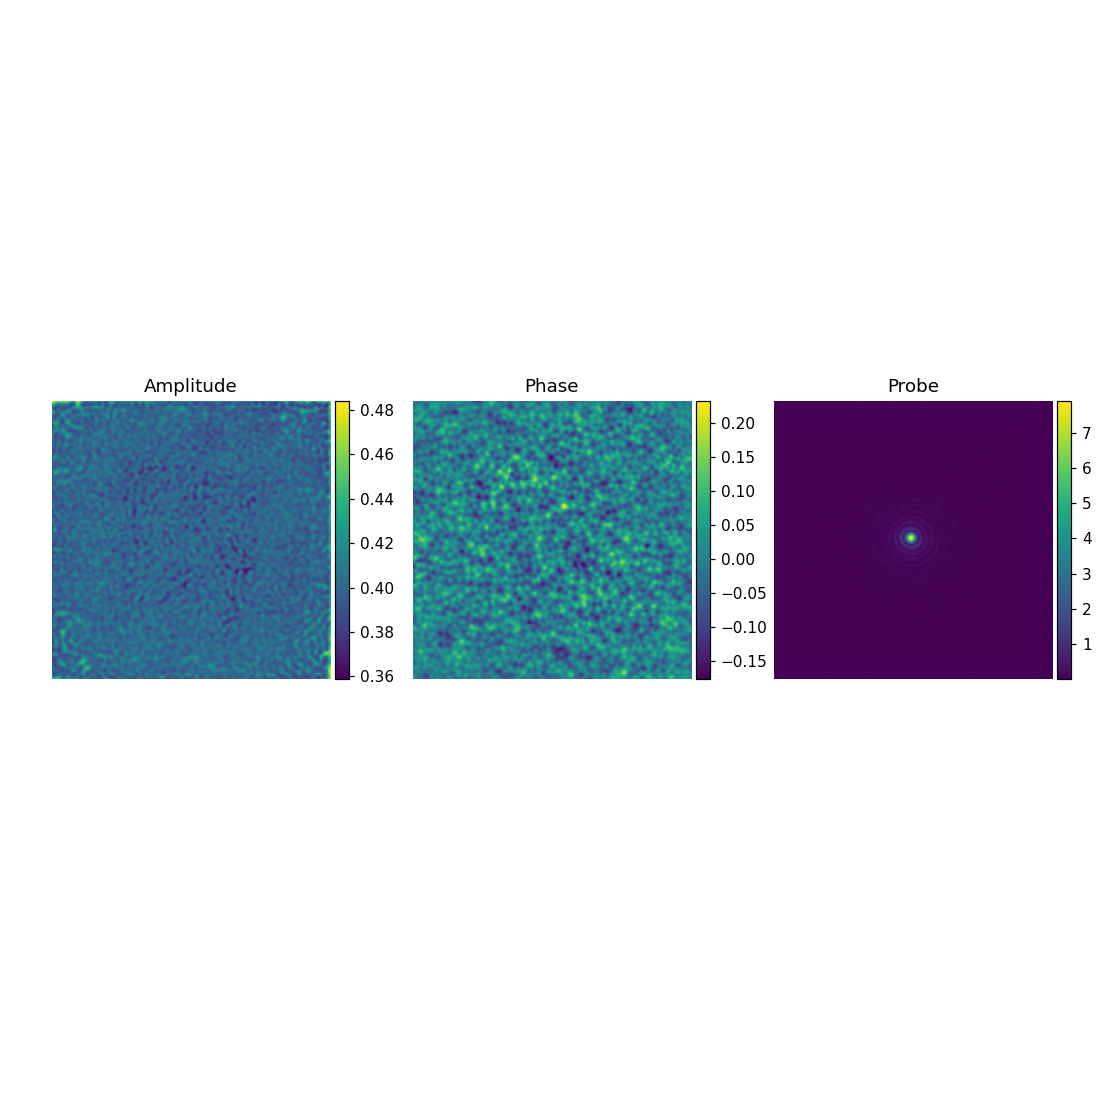

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
os.chdir(path)
prev_recon_name = data_dir + result_dir_extra0+ "_" + result_dir_extra_opt + "/" +  "recon_Niter50" + ".mat"
prev_recon_data = sio.loadmat(prev_recon_name)
print(prev_recon_name)
obj = prev_recon_data['object']
probe = prev_recon_data['probes']
px = prev_recon_data['ppX']
py = prev_recon_data['ppY']
dx = prev_recon_data['dx_x']
print(np.shape(obj))
print("dx=",dx)
print(rot_angle_d)
obj_crop = postProcess.postProcess(obj, rot_angle_d, px, py, dx)

print(np.shape(obj_crop))
fig0, ax0 = plt.subplots(nrows=1, ncols=3, figsize = (10,10))
fig0.tight_layout()
a = ax0[0].imshow(np.abs(obj_crop))
divider = make_axes_locatable(ax0[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(a,cax = cax)
ax0[0].set_title('Amplitude')
ax0[0].axis('off')

b = ax0[1].imshow(np.angle(obj_crop) )
divider = make_axes_locatable(ax0[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(b,cax = cax)
ax0[1].set_title('Phase')  
ax0[1].axis('off')

c = ax0[2].imshow(np.abs(probe[0,:,:]))
divider = make_axes_locatable(ax0[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(c,cax = cax)
ax0[2].set_title('Probe')      
ax0[2].axis('off')

fig0.savefig('/srv/home/jwei74/Ptychography/20211016/movie336/mos2_WS2_test1_optimization_result.tif', dpi = 300)

### CHECKPOINT 8:
<span style="color:red"> We have now run more iterations and included position refinements. Do you see improvments?

Better SNR;

ShaRper atoms and more clear background.

[go to top](#toc)
## 10. Higher resolution using multiple probe modes (optional) <a name="multiple"/>
Electron probe is not a perfect coherent probe. The partial coherence can be modeled by using multiple probe modes, i.e., a mixed-state probe.

In [ ]:
############## mixed-states recon ############## (something might be wrong)
## Let's restore the correct parameters from data

alpha_max = squeeze(data['alpha_max']) # mrad
scanStepSize_x = squeeze(data['scanStepSize_x'])
scanStepSize_y = squeeze(data['scanStepSize_y'])
probe_init.alpha_max = alpha_max

N_roi = 128 #Size of square diffraction patterns

dk = squeeze(data['dk']) # reciprocal space pixel size (inverse angstrom)
dx = 1.0/dk/N_roi # real space pixel size (angstrom)
ppX, ppY, result_dir_extra = utils.calculate_scan_positions(N_scan_x, N_scan_y, scanStepSize_x, scanStepSize_y, rot_angle_d, result_dir_extra)

Ny_max = max([abs(round(np.min(ppY)/dx)-floor(N_roi/2.0)), abs(round(np.max(ppY)/dx)+ceil(N_roi/2.0))])*2+1
Nx_max = max([abs(round(np.min(ppX)/dx)-floor(N_roi/2.0)), abs(round(np.max(ppX)/dx)+ceil(N_roi/2.0))])*2+1

#Extend the size of the object to accommondate position correction, and will crop later
N_image = int(max([Ny_max,Nx_max]))+20


reconObject = pty.ptycho(dp, dk, probe_init, ppX, ppY)
reconObject.paraDict['dk_y'] = dk
reconObject.paraDict['dk_x'] = dk
reconObject.paraDict['N_image'] = N_image 
reconObject.paraDict['N_roi'] = N_roi #Size of ROI
reconObject.paraDict['Niter'] = 20 #Number of iterations
reconObject.paraDict['Niter_update_probe'] = 0 #Update probe from the 1st iteration
reconObject.paraDict['Niter_save'] = 5 #How often to save the reconstruction results

reconObject.paraDict['beta'] = 1 #Learning rate for updating probe
reconObject.paraDict['alpha'] = 0.1 #Learning rate for updating object

reconObject.paraDict['rotationAngle']  = rot_angle_d

########################################################

os.chdir(path)
reconObject.paraDict['N_probe'] = 3 #number of probes
reconObject.paraDict['N_object'] = 1 #default = 1
#reconObject.paraDict['Niter_update_states'] = 50
reconObject.paraDict['Niter_update_states'] = 0 #Since which iteration to do mixed-state update

result_dir_extra_mixed = 'mixed_state'

print("probe modes:",reconObject.paraDict['N_probe'])

############## load existing probe and object ##############

prev_recon_name = data_dir + "/mos2_" + result_dir_extra0 + "_" + result_dir_extra_opt + "/" + "recon_Niter40" + ".mat"
print(prev_recon_name)
prev_recon_data = sio.loadmat(prev_recon_name)
#reconObject.paraDict['previous_probe'] = prev_recon_data['probes'] #mixed states opr\n",
#reconObject.paraDict['previous_obj'] = prev_recon_data['object'] #mixed states opr\n",
reconObject.paraDict['Niter'] = 40 #Number of iterations
reconObject.paraDict['Niter_save'] = 10 #How often to save the reconstruction results
############## position correction ##############
reconObject.paraDict['Niter_update_position'] = 40 #Since which iteration to update positions

result_dir = data_dir + "/mos2_" + result_dir_extra0 + '_' + result_dir_extra_mixed
result_dir_extra = reconObject.initialize(result_dir) #Load the predefined parameters

#print(reconObject.paraDict['saveName'])
start_time = time.time()
reconObject.recon() #start reconstruction
total_time = time.time() - start_time

timeLeftMin, timeLeftSec = divmod(total_time, 60)
timeLeftHour, timeLeftMin = divmod(timeLeftMin, 60)
print('Total recon time: %02d:%02d:%02d' %(timeLeftHour,timeLeftMin,timeLeftSec))

Please create your own code to plot the probe modes and object function. Now there are more than one probe modes, you can check the size/dimension of the probes.


In [ ]:
os.chdir(path)
#### plotting ...
prev_recon_name = data_dir + "/mos2_" + result_dir_extra0+ "_" + result_dir_extra_mixed + "/" +  "recon_Niter40" + ".mat"
prev_recon_data = sio.loadmat(prev_recon_name)
print(prev_recon_name)
obj = prev_recon_data['object']
probe = prev_recon_data['probes']
px = prev_recon_data['ppX']
py = prev_recon_data['ppY']
dx = prev_recon_data['dx_x']
print(np.shape(obj))
print("dx=",dx)
print(rot_angle_d)
obj_crop = postProcess.postProcess(obj, rot_angle_d, px, py, dx)

print(np.shape(obj_crop))
print(probe.shape[0])
fig0, ax0 = plt.subplots(nrows=1, ncols=probe.shape[0])
fig0.tight_layout()
for jj in range(probe.shape[0]):
    ax0[jj].imshow(np.abs(probe[jj,:,:]))
    ax0[jj].set_title('Mode #' + str(jj+1) ) 
    
fig1, ax1 = plt.subplots(nrows=1, ncols=2)
fig1.tight_layout()
ax1[0].imshow(np.abs(obj_crop))
ax1[0].set_title('Amplitude')      
ax1[1].imshow(np.angle(obj_crop) )
ax1[1].set_title('Phase') 

[go to top](#toc)